# <font color=#264653><u>Ocular Disease Recognition</u></font>

## <font color=#264653><u>Imports</u></font>

In [1]:
import os
os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"

import tensorflow as tf
import tensorflow_addons as tfa
import pandas as pd
pd.options.mode.chained_assignment = None;
import numpy as np

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.manifold import TSNE

from tensorflow.keras.applications import MobileNetV3Small

from kaggle_datasets import KaggleDatasets
from collections import Counter

import random
import re

import matplotlib as mpl
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

def seed_it_all(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_it_all()

print(f"\n...COMPLETED IMPORT...")

ModuleNotFoundError: No module named 'tensorflow'

## <font color=#264653><u>Accelerator Setup</u></font>

In [ ]:
try:
    TPU = tf.distribute.cluster_resolver.TPUClusterResolver()  
except ValueError:
    TPU = None

if TPU:
    print(f"\n... RUNNING ON TPU - {TPU.master()} ...")
    tf.config.experimental_connect_to_cluster(TPU)
    tf.tpu.experimental.initialize_tpu_system(TPU)
    strategy = tf.distribute.experimental.TPUStrategy(TPU)
else:
    print(f"\n... RUNNING ON CPU/GPU ...")
    physical_devices = tf.config.list_physical_devices('GPU')
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
    except:
        # Invalid device or cannot modify virtual devices once initialized.
        pass
    strategy = tf.distribute.get_strategy()

N_REPLICAS = strategy.num_replicas_in_sync
    
print(f"... # OF REPLICAS: {N_REPLICAS} ...\n")


... RUNNING ON CPU/GPU ...
... # OF REPLICAS: 1 ...



## <font color=#264653><u>Data Loading</u></font>

In [ ]:
DATA_PATH_INIT = r"C:\Users\gokus\PycharmProjects\pythonProject\minorProject\dataset\ODIR-5K\ODIR-5K"

if TPU:
    # Google Cloud Dataset path to training and validation images
    DATA_DIR = KaggleDatasets().get_gcs_path(DATA_PATH_INIT)
    save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
    load_locally = tf.saved_model.LoadOptions(experimental_io_device='/job:localhost')
else:
    # Local path to training and validation images
    DATA_DIR = DATA_PATH_INIT
    save_locally = None
    load_locally = None

print(f"\n... DATA DIRECTORY PATH IS:\n\t--> {DATA_DIR}")

print(f"\n... IMMEDIATE CONTENTS OF DATA DIRECTORY IS:")
for file in tf.io.gfile.glob(os.path.join(DATA_DIR, "*")): print(f"\t--> {file}")

print("\n\n... DATA ACCESS SETUP COMPLETED ...\n")


... DATA DIRECTORY PATH IS:
	--> /kaggle/input/ocular-disease-recognition-odir5k

... IMMEDIATE CONTENTS OF DATA DIRECTORY IS:
	--> /kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images
	--> /kaggle/input/ocular-disease-recognition-odir5k/ODIR-5K
	--> /kaggle/input/ocular-disease-recognition-odir5k/full_df.csv


... DATA ACCESS SETUP COMPLETED ...



In [4]:
df = pd.read_csv(os.path.join("/kaggle/input", DATA_PATH_INIT, "full_df.csv"))

In [5]:
df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


## <font color=#264653><u>Constants and Helper Functions</u></font>

In [6]:
labels_long = ["Normal", "Diabetes", "Glaucoma", "Cataract", "AMD", "Hypertension", "Myopia", "Other"]
labels_short = [ll[0] for ll in labels_long]

class_short2full = {
    ls: ll
    for ls, ll in zip(labels_short, labels_long)
}

class_dict = {class_ : i for i, class_ in enumerate(class_short2full.keys())}
class_dict_rev = {v: k for k, v in class_dict.items()}

NUM_CLASSES = len(class_dict)

In [7]:
SEED = 42

COLORS = {"fig_bg": "#f6f5f5", "plot_neut": "#ddbea9", "plot_text": "#343a40",
          "cmap_color_list": ["#001219", "#005F73", "#0A9396", "#94D2BD", "#E9D8A6",
                              "#EE9B00", "#CA6702", "#BB3E03", "#AE2012", "#9B2226"], "split": {
        "train": "#264653",
        "val": "#2a9d8f",
        "test": "#e9c46a"
    }}

COLORS["class"] = {ls: c for ls, c in zip(class_short2full.keys(), COLORS["cmap_color_list"][:len(class_short2full.keys())])}
COLORS["cmap"] = mpl.colors.LinearSegmentedColormap.from_list("", COLORS["cmap_color_list"])
COLORS["cmap_pos"] = mpl.colors.LinearSegmentedColormap.from_list("", ["#F0F3F8", "#D1DBE9", "#A2B7D2", "#7493BC", "#6487B4", "#3D5A80"])

colors_class_list = list(COLORS["class"].values())

FONT_KW = {
    "plot_title" : {
        "fontname": "serif",
        "weight": "bold",
        "size": "25",
        "style": "normal"
    },
    "plot_title_small" : {
        "fontname": "serif",
        "weight": "bold",
        "size": "16",
        "style": "normal"
    },
    "plot_subtitle" : {
        "fontname": "serif",
        "weight": "bold",
        "size": "12",
        "style": "normal"
    },
    "subplot_title" : {
        "fontname": "serif",
        "weight": "bold",
        "size": "18",
        "style": "normal"
    },
    "subplot_title_small" : {
        "fontname": "serif",
        "weight": "bold",
        "size": "12",
        "style": "normal"
    },
    "plot_label" : {
        "fontname": "serif",
        "weight": "bold",
        "size": "16",
        "style": "normal"
    },
    "plot_label_small" : {
        "fontname": "serif",
        "weight": "bold",
        "size": "12",
        "style": "normal"
    },
    "plot_text" : {
        "fontname": "serif",
        "weight": "normal",
        "size": "12",
        "style": "normal"
    },
    "plot_text_small" : {
        "fontname": "serif",
        "weight": "normal",
        "size": "8",
        "style": "normal"
    },
}

In [ ]:
def count_values_relative(y):
    bins, vals = np.unique(y, return_counts=True)
    return bins, 100 * vals / np.sum(vals)

def ceil_d(n, d=1000):
    return int(np.ceil(n / d) * d)

def get_subplot_dims(N):
    r = np.ceil(np.sqrt(N))
    c = np.floor(np.sqrt(N))
    if r*c < N:
        r += 1
    return int(r), int(c)


def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

def natural_sort_col_unique(df, colname, missing="NA"):
    arr = df[colname].unique().tolist()
    if np.nan in arr:
        arr[arr.index(np.nan)] = missing
    arr.sort(key=natural_keys)
    return arr

    
def conditional_entropy(x,y):
    # entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy

def theil_u(x,y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x
    
def correlation_ratio(categories, measurements):
    if isinstance(categories, pd.Series):
        categories = categories.values
    if isinstance(measurements, pd.Series):
        measurements = measurements.values
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat) + 1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0, cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array, n_array)) / np.sum(n_array)
    numerator = np.sum(
        np.multiply(n_array, np.power(np.subtract(y_avg_array, y_total_avg),
                                      2)))
    denominator = np.sum(np.power(np.subtract(measurements, y_total_avg), 2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator / denominator)
    return eta

In [ ]:
DATA_PATH = r"C:\Users\gokus\PycharmProjects\pythonProject\minorProject\dataset\ODIR-5K\ODIR-5K"
IMG_SIZE = 224
IMAGE_SIZE = [IMG_SIZE, IMG_SIZE]

def label_image(c):
    label = np.full((NUM_CLASSES), 0, dtype=int)
    label[c] = 1
    return label

def get_gaussian_filter_shape(IMG_SIZE):
    return IMG_SIZE//4 - 1

def blur_image(image, sigma=10):
    filter_shape=get_gaussian_filter_shape(IMG_SIZE)
    return tfa.image.gaussian_filter2d(image, filter_shape=filter_shape, sigma=sigma)

def weighted_image(image, alpha=4, beta=-4, gamma=128):
    return image*alpha + blur_image(image)*beta + gamma

def create_dataset(dataset, img_list, class_label, augment={}):
    for img in img_list:
        image_path = os.path.join(DATA_PATH, img)
        image_label = label_image(class_label)
        try:
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image,(IMG_SIZE, IMG_SIZE))
            image = weighted_image(image)
        except:
            continue
        
        dataset.append([np.array(image), image_label])
        
        if augment:
            if class_label in augment.keys():
                if augment[class_label]:
                    image_lr = tf.image.flip_left_right(image)
                    image_ud = tf.image.flip_up_down(image)
                    image_rot90 = tf.image.rot90(image, k=1)
                    image_rot180 = tf.image.rot90(image, k=2)
                    image_rotm90 = tf.image.rot90(image, k=-1)
                    
                    dataset.append([np.array(image_lr), image_label])
                    dataset.append([np.array(image_ud), image_label])
                    dataset.append([np.array(image_rot90), image_label])
                    dataset.append([np.array(image_rot180), image_label])
                    dataset.append([np.array(image_rotm90), image_label])
        
    random.shuffle(dataset)
    return dataset

## <font color=#264653><u>Exploratory Data Analysis</u></font>

In [10]:
df_eda = df.copy()

In [11]:
df_eda["class"] = df_eda["labels"].apply(lambda x: " ".join(re.findall("[a-zA-Z]+", x)))

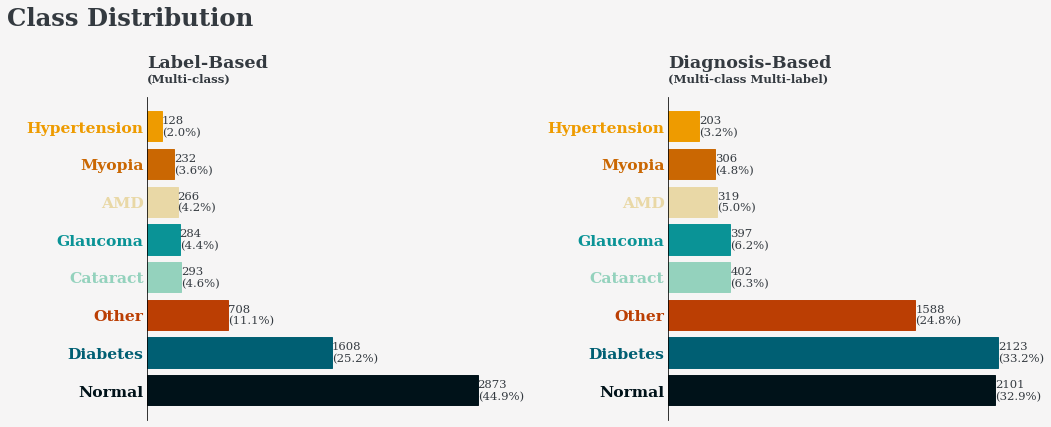

In [12]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6), dpi=70, gridspec_kw={"wspace": 0.5})

fig.patch.set_facecolor(COLORS["fig_bg"])

value_counts = df_eda["class"].value_counts().rename("num").to_frame()
value_counts["percent"] = value_counts / value_counts.sum()
value_counts.reindex(index=COLORS["class"].keys())

b1 = ax1.barh(value_counts.index, value_counts["percent"])

ax1.set_yticks(
    value_counts.index,
    [class_short2full[i] for i in value_counts.index],
    **FONT_KW["plot_label"], color=COLORS["plot_text"]
)
ax1.tick_params(axis="y", length=0)
ax1.set_title("Label-Based", loc="left", **FONT_KW["subplot_title"], color=COLORS["plot_text"], pad=30)
ax1.text(0, 8.2, "(Multi-class)", **FONT_KW["subplot_title_small"], color=COLORS["plot_text"])

ax1.bar_label(
    b1,
    labels=[str(val) + f"\n({str(np.round(100*pcnt,1))}%)" for val, pcnt in zip(value_counts["num"], value_counts["percent"])],
    color=COLORS["plot_text"],
    **FONT_KW["plot_text"]
)

ax1.set_facecolor(COLORS["fig_bg"])
for i in range(NUM_CLASSES):
    c = COLORS["class"][value_counts.index[i]]
    ax1.get_yticklabels()[i].set_color(c)
    b1[i].set_color(c)

ax1.axes.get_xaxis().set_visible(False)

for spine in ["bottom", "right", "top"]:
    ax1.spines[spine].set_visible(False)


value_count_diag = df_eda[labels_short].sum().rename("num").to_frame()
value_count_diag["percent"] = value_count_diag / df_eda.shape[0]
value_count_diag = value_count_diag.reindex(index=value_counts.index)

b2 = ax2.barh(value_count_diag.index, value_count_diag["percent"])

ax2.set_yticks(
    value_count_diag.index,
    [class_short2full[i] for i in value_count_diag.index],
    **FONT_KW["plot_label"], color=COLORS["plot_text"]
)
ax2.tick_params(axis="y", length=0)
ax2.set_title("Diagnosis-Based", loc="left", **FONT_KW["subplot_title"], color=COLORS["plot_text"], pad=30)
ax2.text(0, 8.2, "(Multi-class Multi-label)", **FONT_KW["subplot_title_small"], color=COLORS["plot_text"])

ax2.bar_label(
    b2,
    labels=[str(val) + f"\n({str(np.round(100*pcnt,1))}%)" for val, pcnt in zip(value_count_diag["num"], value_count_diag["percent"])],
    color=COLORS["plot_text"],
    **FONT_KW["plot_text"]
)

ax2.set_facecolor(COLORS["fig_bg"])
for i in range(NUM_CLASSES):
    c = COLORS["class"][value_count_diag.index[i]]
    ax2.get_yticklabels()[i].set_color(c)
    b2[i].set_color(c)

ax2.axes.get_xaxis().set_visible(False)

for spine in ["bottom", "right", "top"]:
    ax2.spines[spine].set_visible(False)
    
plt.figtext(0, 1.05, "Class Distribution", **FONT_KW["plot_title"], color=COLORS["plot_text"])

plt.show()

In [13]:
df["class"] = df["labels"].apply(lambda x: " ".join(re.findall("[a-zA-Z]+", x)))

In [14]:
dict_img_list = {
    class_: df.loc[df["class"]==class_]["filename"].values
    for class_ in class_short2full.keys()
}

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_classes(X, y, min_distance=0.05, images=None, figsize=(13, 10), cmap=COLORS["cmap"], annot=False):
    # transform images to fit in range [0, 1]
    X_normalized = MinMaxScaler().fit_transform(X)
    neighbors = np.array([[10., 10.]])
    fig, ax = plt.subplots(figsize=figsize)
    classes = np.unique(y)
    n_classes = len(classes)
    for class_ in classes:
        ax.scatter(
            X_normalized[y == class_, 0],
            X_normalized[y == class_, 1],
            c=COLORS["class"][class_dict_rev[class_]],
            alpha=0.7,
        )
    
    if annot:
        for index, image_coord in enumerate(X_normalized):
            closest_distance = np.linalg.norm(neighbors - image_coord, axis=1).min()
            if closest_distance > min_distance:
                neighbors = np.r_[neighbors, [image_coord]]
                if images is None:
                    ax.text(
                        image_coord[0],
                        image_coord[1],
                        class_dict_rev[y[index]],
                        color=COLORS["class"][class_dict_rev[y[index]]],
                        alpha=0.7,
                        **FONT_KW["plot_text_small"]
                    )
                else:
                    image = images[index].reshape(28, 28)
                    imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"), image_coord)
                    ax.add_artist(imagebox)
    
    fig.patch.set_facecolor(COLORS["fig_bg"])
    ax.set_facecolor(COLORS["fig_bg"])
    ax.axis("off")
    
    ax.legend(
        [class_short2full[class_dict_rev[label]] for label in np.unique(y)],
        prop={"family": "serif", "size": 8},
        facecolor=COLORS["fig_bg"]
    )
    
    plt.show()

In [16]:
n_images_per_class = 50
rng = np.random.default_rng(seed=SEED)

for class_ in class_dict.keys():
    ind = rng.choice(len(dict_img_list[class_]), n_images_per_class, replace=False)
    dict_img_list[class_] = dict_img_list[class_][ind]

In [17]:
NUM_CLASSES = len(class_dict)
dataset_viz = []
print("START building visualization dataset")
for i, class_ in enumerate(class_dict.keys()):
    print(f"[{i+1}/{len(class_dict)}] adding {class_short2full[class_]} to dataset ...")
    dataset_viz = create_dataset(dataset_viz, dict_img_list[class_], class_dict[class_])
print("COMPLETE building visualization dataset")

START building visualization dataset
[1/8] adding Normal to dataset ...
[2/8] adding Diabetes to dataset ...
[3/8] adding Glaucoma to dataset ...
[4/8] adding Cataract to dataset ...
[5/8] adding AMD to dataset ...
[6/8] adding Hypertension to dataset ...
[7/8] adding Myopia to dataset ...
[8/8] adding Other to dataset ...
COMPLETE building visualization dataset


In [18]:
X_viz = np.array([i[0] for i in dataset_viz]).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y_viz = np.array([i[1] for i in dataset_viz])

In [19]:
tsne = TSNE(
    n_components=2,
    init="pca",
    learning_rate="auto",
    perplexity=50,
    n_iter=5000,
    random_state=SEED
)
  
X_viz = X_viz.reshape((X_viz.shape[0], np.prod(X_viz.shape[1:])))
X_tsne_reduced = tsne.fit_transform(X_viz)

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


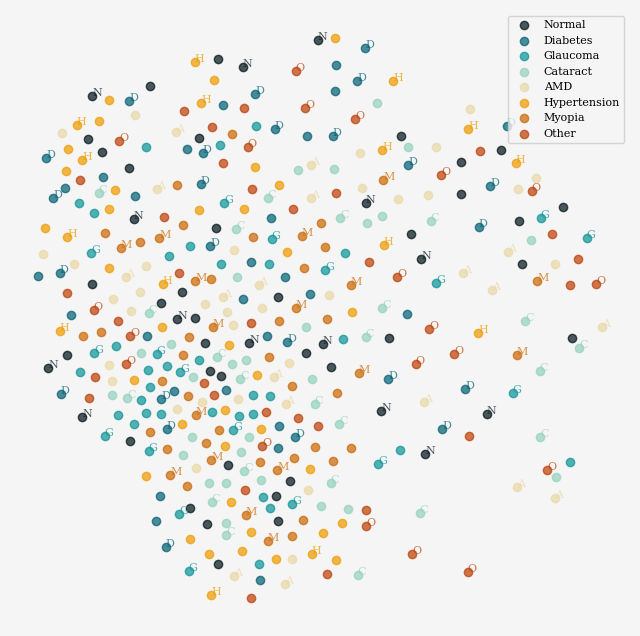

In [20]:
plot_classes(X_tsne_reduced, y_viz.argmax(axis=1), figsize=(8,8), annot=True, min_distance=0.05)

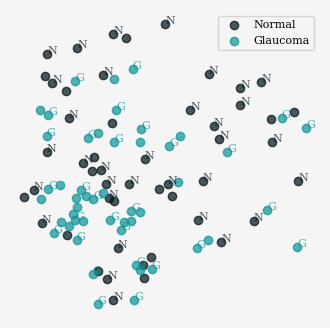

In [21]:
y_viz_label = y_viz.argmax(axis=1)
ind_selected_samples = (y_viz_label == class_dict["N"]) | (y_viz_label == class_dict["G"])
plot_classes(X_tsne_reduced[ind_selected_samples], y_viz_label[ind_selected_samples], figsize=(4,4), annot=True, min_distance=0.05)

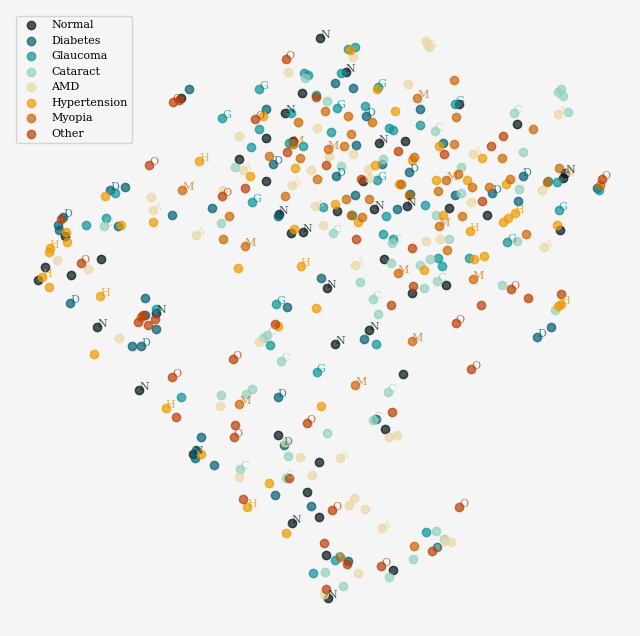

In [22]:
from umap import UMAP

reducer = UMAP()

X_umap_reduced = reducer.fit_transform(X_viz)
plot_classes(X_umap_reduced, y_viz.argmax(axis=1), figsize=(8,8), annot=True, min_distance=0.05)

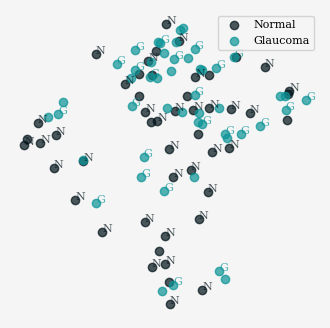

In [23]:
plot_classes(X_umap_reduced[ind_selected_samples], y_viz_label[ind_selected_samples], figsize=(4,4), annot=True, min_distance=0.05)

## <font color=#264653><u>Generating Dataset</u></font>

In [24]:
CLASSES = ["N", "G"]
NUM_CLASSES = len(CLASSES)

class_dict = {class_ : i for i, class_ in enumerate(CLASSES)}
class_dict_rev = {v: k for k, v in class_dict.items()}

df = df.loc[df["class"].isin(CLASSES)]

dict_img_list = {
    class_: df.loc[df["class"]==class_]["filename"].values
    for class_ in CLASSES
}

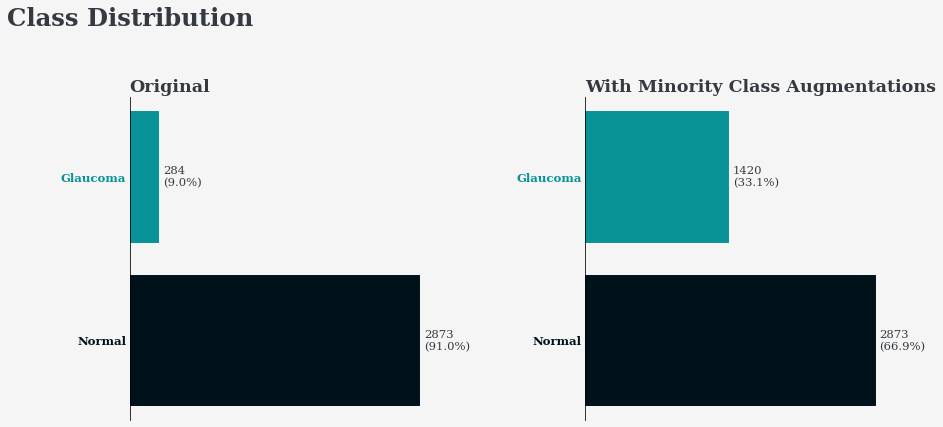

In [25]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14,6), dpi=70, gridspec_kw={"wspace": 0.5})

fig.patch.set_facecolor(COLORS["fig_bg"])

value_counts = df["class"].value_counts().rename("num").to_frame()
value_counts["percent"] = value_counts / value_counts.sum()
value_counts.reindex(index=CLASSES)

b1 = ax1.barh(value_counts.index, value_counts["percent"])

ax1.set_yticks(
    value_counts.index,
    [class_short2full[i] for i in value_counts.index],
    **FONT_KW["plot_label_small"], color=COLORS["plot_text"]
)
ax1.tick_params(axis="y", length=0)
ax1.set_title("Original", loc="left", **FONT_KW["subplot_title"], color=COLORS["plot_text"])

ax1.bar_label(
    b1,
    labels=[str(val) + f"\n({str(np.round(100*pcnt,1))}%)" for val, pcnt in zip(value_counts["num"], value_counts["percent"])],
    padding=5,
    color=COLORS["plot_text"],
    **FONT_KW["plot_text"]
)

ax1.set_facecolor(COLORS["fig_bg"])

for i in range(NUM_CLASSES):
    c = COLORS["class"][value_counts.index[i]]
    ax1.get_yticklabels()[i].set_color(c)
    b1[i].set_color(c)

ax1.axes.get_xaxis().set_visible(False)

for spine in ["bottom", "right", "top"]:
    ax1.spines[spine].set_visible(False)


NUM_AUGMENTATIONS = 5
value_counts_aug = value_counts.copy()
value_counts_aug.loc["G", "num"] *= NUM_AUGMENTATIONS
value_counts_aug["percent"] = value_counts_aug["num"] / value_counts_aug["num"].sum()
    
b2 = ax2.barh(value_counts_aug.index, value_counts_aug["percent"])

ax2.set_yticks(
    value_counts_aug.index,
    [class_short2full[i] for i in value_counts_aug.index],
    **FONT_KW["plot_label_small"], color=COLORS["plot_text"]
)
ax2.tick_params(axis="y", length=0)
ax2.set_title("With Minority Class Augmentations", loc="left", **FONT_KW["subplot_title"], color=COLORS["plot_text"])

ax2.bar_label(
    b2,
    labels=[str(val) + f"\n({str(np.round(100*pcnt,1))}%)" for val, pcnt in zip(value_counts_aug["num"], value_counts_aug["percent"])],
    padding=5,
    color=COLORS["plot_text"],
    **FONT_KW["plot_text"]
)

ax2.set_facecolor(COLORS["fig_bg"])

for i in range(NUM_CLASSES):
    c = COLORS["class"][value_counts_aug.index[i]]
    ax2.get_yticklabels()[i].set_color(c)
    b2[i].set_color(c)

ax2.axes.get_xaxis().set_visible(False)

for spine in ["bottom", "right", "top"]:
    ax2.spines[spine].set_visible(False)
    
plt.figtext(0, 1.05, "Class Distribution", **FONT_KW["plot_title"], color=COLORS["plot_text"])
plt.show()

In [26]:
augment = {
    class_dict["N"]: False,
    class_dict["G"]: True,
}

dataset = []
print("START building dataset")
for i, class_ in enumerate(CLASSES):
    print(f"[{i+1}/{len(CLASSES)}] adding {class_short2full[class_]} to dataset ...")
    dataset = create_dataset(dataset, dict_img_list[class_], class_dict[class_], augment=augment)
print("COMPLETE building dataset")

START building dataset
[1/2] adding Normal to dataset ...
[2/2] adding Glaucoma to dataset ...
COMPLETE building dataset


In [27]:
X = np.array([i[0] for i in dataset]).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.array([i[1] for i in dataset])

### <font color=#264653><u>Data Sampling</u></font>

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X , y, test_size=0.2, stratify=y, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train , y_train, test_size=0.25, stratify=y_train, random_state=SEED)

In [29]:
def plot_samples(n_images_per_class=8, figsize=(8, 8), seed=SEED):
    rng = np.random.default_rng(seed=seed)

    num_images = n_images_per_class*NUM_CLASSES
    nrows, ncols = get_subplot_dims(num_images)

    idx_neg = np.concatenate(
        (
            np.arange(start=1, stop=num_images, step=nrows),
            np.arange(start=1, stop=num_images, step=nrows)+1
        )
    )
    idx_neg.sort()

    images_neg = X_train[y_train.argmax(axis=1)==0]
    ind_neg = rng.choice(len(images_neg), n_images_per_class, replace=False)

    images_pos = X_train[y_train.argmax(axis=1)==1]
    ind_pos = rng.choice(len(images_pos), n_images_per_class, replace=False)

    fig = plt.figure(figsize=figsize, tight_layout=True)
    count_neg = 0
    count_pos = 0
    for row in range(nrows):
        for col in range(ncols):
            img_ind = row*ncols + col + 1
            ax = plt.subplot(nrows, ncols, img_ind)
            if img_ind in idx_neg:
                ax.imshow(images_neg[ind_neg[count_neg]])
                count_neg += 1
                ax.set_title(class_short2full[class_dict_rev[0]], color=COLORS["class"][class_dict_rev[0]], **FONT_KW["subplot_title_small"])
            else:
                ax.imshow(images_pos[ind_pos[count_pos]])
                count_pos += 1
                ax.set_title(class_short2full[class_dict_rev[1]], color=COLORS["class"][class_dict_rev[1]], **FONT_KW["subplot_title_small"])
            ax.axis("off")
    plt.show()

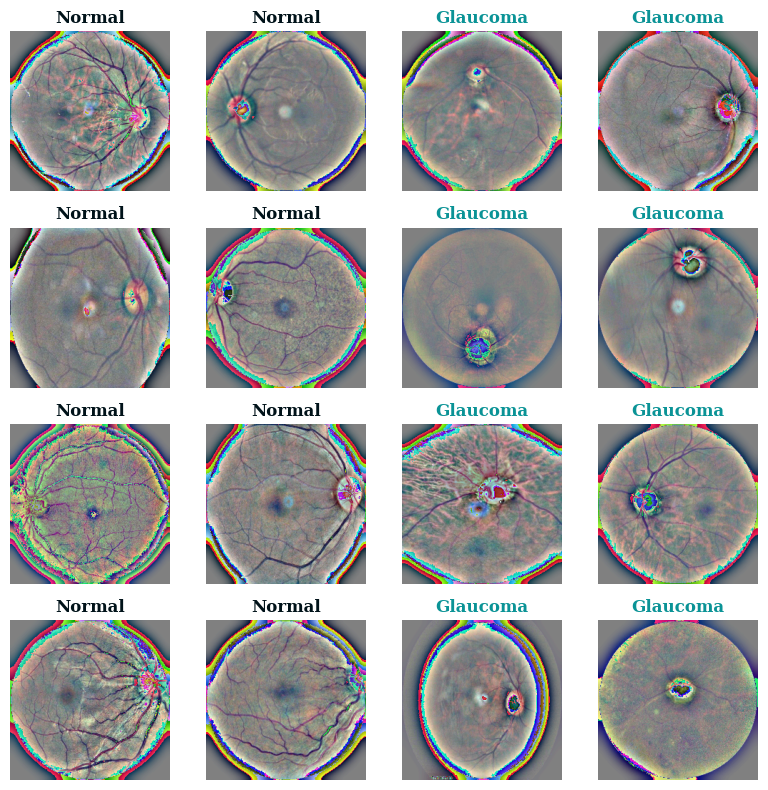

In [30]:
plot_samples()

## <font color=#264653><u>Model</u></font>

In [31]:
def plot_train(history, start_epoch=0, is_shift_val=True, suptitle=None, subtitle=None, **fig_opts):
    history_df = pd.DataFrame(history.history)
    mets = history_df.columns[history_df.columns.str.startswith("val")].str.replace("val_","").tolist()
    L = history_df.shape[0]
    
    nrows, ncols = get_subplot_dims(len(mets))

    fig = plt.figure(**fig_opts)
    fig.subplots_adjust(hspace=0.75, wspace=0.75)
    fig.patch.set_facecolor(COLORS["fig_bg"])
    
    for i,met in enumerate(mets):
        if met=="loss":
            value_train = np.round(history_df[met].min(),4)
            value_val = np.round(history_df["val_"+met].min(),4)
        else:
            value_train = np.round(history_df[met].max(),4)
            value_val = np.round(history_df["val_"+met].max(),4)
            
        ax = plt.subplot(nrows, ncols, i+1)
        
        ax.plot(np.arange(start_epoch, L), history_df[met].iloc[start_epoch:], color=COLORS["split"]["train"])
        ax.plot(np.arange(start_epoch - is_shift_val*0.5, L - is_shift_val*0.5), history_df["val_"+met].iloc[start_epoch:], color=COLORS["split"]["val"])
        
        ax.set_title(met, **FONT_KW["subplot_title_small"], pad=30)
        ax.set_xlabel("epoch", **FONT_KW["plot_text_small"])
        ax.set_ylabel("")
        ax.legend(["train", "validation"], prop={"family": "serif", "size": 8}, facecolor=COLORS["fig_bg"])
            
        plt.xticks(**FONT_KW["plot_text_small"])
        plt.yticks(**FONT_KW["plot_text_small"])
        
        ax.text(
            0.5, 1.1,
            f"Best train {met}: {value_train}\n" +\
            f"Best val {met}: {value_val}",
            **FONT_KW["plot_text_small"],
            color=COLORS["plot_text"],
            transform=ax.transAxes,
            ha="center",
            bbox={
                "boxstyle": "Round",
                "fill": False,
                "edgecolor": COLORS["plot_text"]
            }
        )
        
        ax.set_facecolor(COLORS["fig_bg"])
        for spine in ["right", "top"]:
            ax.spines[spine].set_visible(False)

    if suptitle is not None:
        plt.suptitle(
            x=0.5, y=1.005,
            t=suptitle,
            ha="center",
            va="bottom",
            **FONT_KW["plot_title_small"],
            color=COLORS["plot_text"]
        )
        
    if subtitle is not None:
        plt.figtext(
            x=0.5, y=0.98,
            s=subtitle,
            ha="center",
            va="bottom",
            **FONT_KW["plot_subtitle"],
            color=COLORS["plot_text"]
        )
    plt.show()

In [32]:
label_count = np.bincount(y_train.argmax(axis=1))
tot = np.sum(label_count)
initial_bias = [np.log(c/tot) for c in label_count]
initial_bias

[-0.4657141174157014, -0.9880195831799813]

In [33]:
class_weight = {c: (1/lc)*(tot/NUM_CLASSES) for c,lc in enumerate(label_count)}
class_weight

{0: 0.7965757399883924, 1: 1.3429549902152642}

In [34]:
effnet_model = MobileNetV3Small(input_shape=(*IMAGE_SIZE, 3), include_top=False, weights="imagenet")

last_layer_include = 5

if last_layer_include is not None:
    for layer in effnet_model.layers[:-last_layer_include]:
        layer.trainable=False
else:
    for layer in effnet_model.layers:
        layer.trainable=False

preprocess_input_effnet = tf.keras.applications.mobilenet_v3.preprocess_input

4334752/4334752 [==============================] - 0s 0us/step


In [35]:
def build_model(base, preprocess_input, output_bias=None, dropout=0.0, L1=1e-3, name="model"):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)

    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 3)),
        
        tf.keras.layers.Lambda(preprocess_input, name='preprocessing'),
        base,
        
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.GlobalAveragePooling2D(),       
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Dense(
            NUM_CLASSES,
            activation='softmax',
            bias_initializer=output_bias,
            kernel_regularizer=tf.keras.regularizers.l1(L1)
        )
    ], name=name)
    
    return model

In [36]:
learning_rate = 3e-4
gamma = 2
dropout = 0.1
L1 = 2e-3

with strategy.scope():
    model = build_model(effnet_model, preprocess_input_effnet, name="effnet_model", output_bias=initial_bias, dropout=dropout, L1=L1)

    METRICS = [
        tf.keras.metrics.AUC(name="auc"),
        tf.keras.metrics.BinaryAccuracy(name="acc"),
        tfa.metrics.F1Score(num_classes=NUM_CLASSES, average="weighted", name="f1"),
        tf.keras.metrics.AUC(name="prc", curve="PR"),
    ]
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.BinaryFocalCrossentropy(gamma=gamma),
        metrics=METRICS
    )

In [37]:
model.summary()

Model: "effnet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocessing (Lambda)      (None, 224, 224, 3)       0         
                                                                 
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 7, 7, 576)         0         
                                                                 
 global_average_pooling2d (G  (None, 576)              0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 576)               0         
                                                                 
 batch_normalization (BatchN  (None, 576)             

In [38]:
EPOCHS = 200
BATCH_SIZE = 128

In [ ]:
# reduce learning rate on plateu
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    factor=0.75,
    patience=10,
    verbose=1,
    min_delta=0.0001,
    cooldown=0,
    min_lr=1e-6,
)

# early stopping
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=EPOCHS//10,
    restore_best_weights=True,
    verbose=1,
)

# checkpoint
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("/working/ocir_model_initial.keras", save_best_only=True)

callbacks = [checkpoint_cb, early_stopping_cb, reduce_lr]

In [40]:
history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    verbose=1,
    callbacks=callbacks,
)

Epoch 1/200
22/22 [==============================] - 12s 156ms/step - loss: 0.4491 - auc: 0.6633 - acc: 0.6291 - f1: 0.6296 - prc: 0.6339 - val_loss: 0.4701 - val_auc: 0.4876 - val_acc: 0.4367 - val_f1: 0.3441 - val_prc: 0.5301 - lr: 3.0000e-04
Epoch 2/200
22/22 [==============================] - 1s 66ms/step - loss: 0.3612 - auc: 0.7716 - acc: 0.7177 - f1: 0.7176 - prc: 0.7503 - val_loss: 0.4252 - val_auc: 0.5364 - val_acc: 0.4847 - val_f1: 0.4224 - val_prc: 0.5662 - lr: 3.0000e-04
Epoch 3/200
22/22 [==============================] - 1s 66ms/step - loss: 0.3184 - auc: 0.8114 - acc: 0.7406 - f1: 0.7396 - prc: 0.7988 - val_loss: 0.3631 - val_auc: 0.6081 - val_acc: 0.5655 - val_f1: 0.5431 - val_prc: 0.6162 - lr: 3.0000e-04
Epoch 4/200
22/22 [==============================] - 1s 66ms/step - loss: 0.2945 - auc: 0.8308 - acc: 0.7621 - f1: 0.7606 - prc: 0.8221 - val_loss: 0.3029 - val_auc: 0.7103 - val_acc: 0.6539 - val_f1: 0.6548 - val_prc: 0.6977 - lr: 3.0000e-04
Epoch 5/200
22/22 [=======

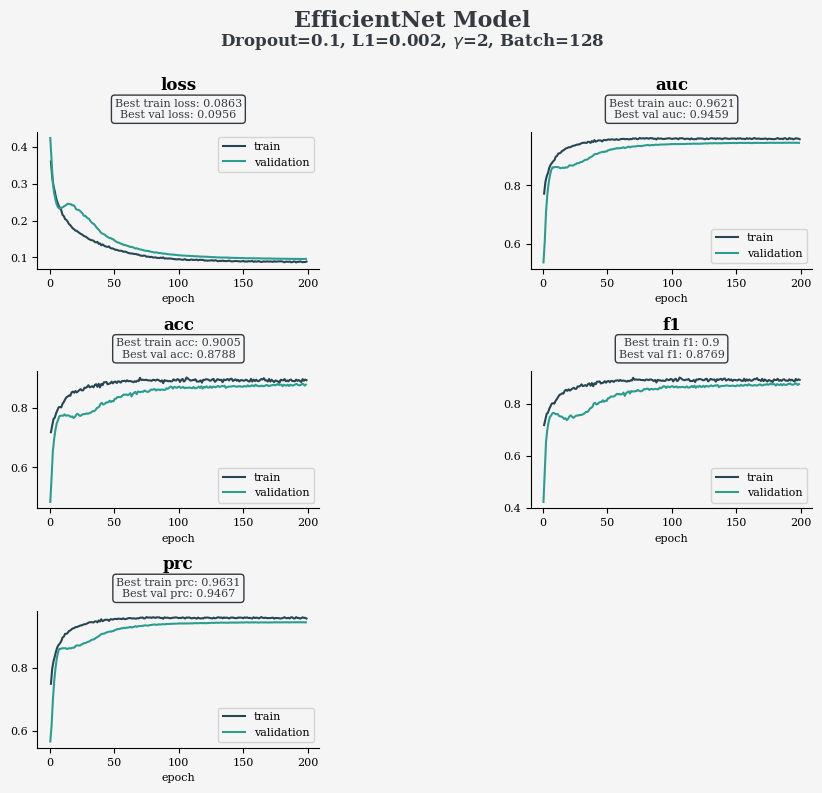

In [41]:
plot_train(history, start_epoch=1, figsize=(10,8), suptitle="EfficientNet Model", subtitle=f"Dropout={dropout}, L1={L1}, $\gamma$={gamma}, Batch={BATCH_SIZE}")

### <font color=#264653><u>Model Evaluation</u></font>

In [42]:
def plot_confusion_matrix(y_true, y_pred, figsize=(16,6), cmap="Blues", suptitle=None):
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = confusion_matrix(y_true, y_pred, normalize="true")
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    fig.patch.set_facecolor(COLORS["fig_bg"])

    sns.heatmap(
        cm,
        annot=True,
        annot_kws=FONT_KW["plot_text"],
        fmt="d",
        linewidths=3.0,
        linecolor=COLORS["fig_bg"],
        cmap=cmap,
        cbar=False,
        square=True,
        xticklabels=[class_short2full[k] for k in class_dict.keys()],
        yticklabels=[class_short2full[k] for k in class_dict.keys()],
        ax=ax1
    )

    ax1.set_title("Confusion Matrix", **FONT_KW["subplot_title_small"])
    ax1.set_xlabel("Predicted Labels", **FONT_KW["plot_label_small"])
    ax1.set_ylabel("True Labels", **FONT_KW["plot_label_small"])
    
    ax1.set_facecolor(COLORS["fig_bg"])
    ax1.tick_params(axis="both", length=0)
    ax1.set_yticks(
        np.arange(len(ax1.get_yticklabels()))+0.5,
        [label.get_text() for label in ax1.get_yticklabels()],
        **FONT_KW["plot_label_small"]
    )
    ax1.set_xticks(
        np.arange(len(ax1.get_xticklabels()))+0.5,
        [label.get_text() for label in ax1.get_xticklabels()],
        **FONT_KW["plot_label_small"]
    )
    
    for class_, i in class_dict.items():
        ax1.get_xticklabels()[i].set_color(COLORS["class"][class_])
        ax1.get_yticklabels()[i].set_color(COLORS["class"][class_])


    sns.heatmap(
        cm_norm,
        annot=True,
        annot_kws=FONT_KW["plot_text"],
        fmt= ".0%" if np.all(np.allclose(cm_norm, cm_norm.astype(int))) else ".1%",
        linewidths=3.0,
        linecolor=COLORS["fig_bg"],
        cmap=cmap,
        cbar=False,
        square=True,
        xticklabels=[class_short2full[k] for k in class_dict.keys()],
        yticklabels=[class_short2full[k] for k in class_dict.keys()],
        ax=ax2
    )

    ax2.set_title("Confusion Matrix (Normalized)", **FONT_KW["subplot_title_small"])
    ax2.set_xlabel("Predicted Labels", **FONT_KW["plot_label_small"])
    ax2.set_ylabel("True Labels", **FONT_KW["plot_label_small"])
    
    ax2.set_facecolor(COLORS["fig_bg"])
    ax2.tick_params(axis="both", length=0)
    ax2.set_yticks(
        np.arange(len(ax2.get_yticklabels()))+0.5,
        [label.get_text() for label in ax2.get_yticklabels()],
        **FONT_KW["plot_label_small"]
    )
    ax2.set_xticks(
        np.arange(len(ax2.get_xticklabels()))+0.5,
        [label.get_text() for label in ax2.get_xticklabels()],
        **FONT_KW["plot_label_small"]
    )
        
    for class_, i in class_dict.items():
        ax2.get_xticklabels()[i].set_color(COLORS["class"][class_])
        ax2.get_yticklabels()[i].set_color(COLORS["class"][class_])
    
    if suptitle is not None:
        plt.suptitle(suptitle, y=0.98, **FONT_KW["plot_title_small"])

    plt.show()

In [43]:
y_val_pred = np.argmax(model.predict(X_val), axis=1)

29/29 [==============================] - 1s 11ms/step


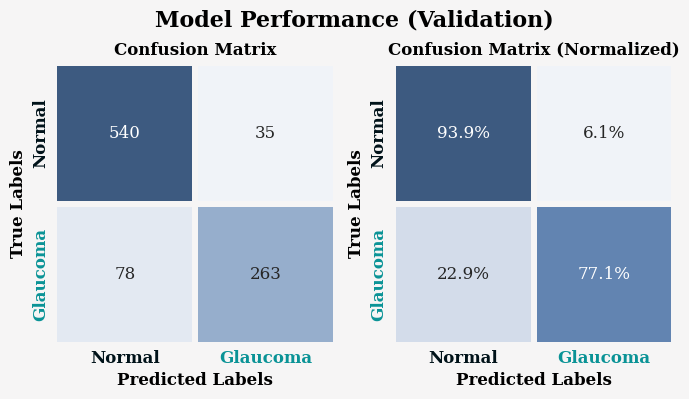

In [44]:
plot_confusion_matrix(
    np.argmax(y_val, axis=1), y_val_pred,
    figsize=(8,4),
    cmap=COLORS["cmap_pos"],
    suptitle="Model Performance (Validation)"
)

In [45]:
y_test_prob = model.predict(X_test)
y_test_pred = np.argmax(y_test_prob, axis=1)

29/29 [==============================] - 0s 11ms/step


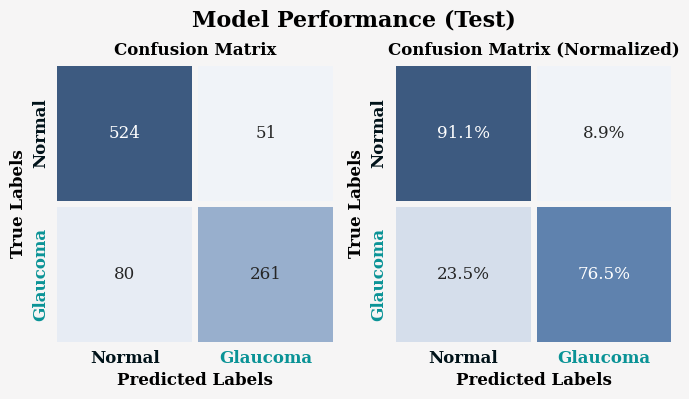

              precision    recall  f1-score   support

      Normal       0.87      0.91      0.89       575
    Glaucoma       0.84      0.77      0.80       341

    accuracy                           0.86       916
   macro avg       0.85      0.84      0.84       916
weighted avg       0.86      0.86      0.86       916

     roc auc       0.93


In [46]:
plot_confusion_matrix(
    np.argmax(y_test, axis=1), y_test_pred,
    figsize=(8,4),
    cmap=COLORS["cmap_pos"],
    suptitle="Model Performance (Test)"
)

report = classification_report(np.argmax(y_test, axis=1), y_test_pred, target_names=[class_short2full[k] for k in class_dict.keys()])
test_roc_auc = roc_auc_score(np.argmax(y_test, axis=1), y_test_prob[:, 1])

print(report)
print(f"     roc auc       {np.round(test_roc_auc, 2)}")

In [ ]:
tflite_model = tf.lite.TFLiteConverter.from_keras_model(model).convert()
with open('/working/ocular.tflite', 'wb') as f:
  f.write(tflite_model)